In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random


class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()        
    
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        self.fc_action2 = nn.Linear(16, 9)
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh()
        
    def forward(self, x):

        y = F.relu(self.conv(x))
        y = y.view(-1, self.size)
        y = F.relu(self.fc(y))        
        
        # the action head
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)
        
        # availability of moves
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
        avail = avail.view(-1, 9)
        
        # locations where actions are not possible, we set the prob to zero
        maxa = torch.max(a)
        
        # subtract off max for numerical stability (avoids blowing up at infinity)
        exp = avail*torch.exp(a-maxa)
        prob = exp/torch.sum(exp)
                
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        
        return prob.view(3,3), value

policy = Policy()

## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

In [2]:
import MCTS

from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(75):
        mytree.explore(policy)
   
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
        
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    


# Training Loop

In [3]:
# initialize our alphazero agent and optimizer
import torch.optim as optim
from ConnectN import ConnectN

game_setting = {'size':(3,3), 'N':3}

game = ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-4)

### Code up the alphazero loss function, defined to be:

$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
Added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [4]:
# train our agent

from collections import deque
import MCTS

episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

for e in range(episodes):

    mytree = MCTS.Node(ConnectN(**game_setting))
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        for _ in range(75):
            mytree.explore(policy)

        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()        
        mytree.detach_mother()
        
        # compute prob* log pi 
        loglist = torch.log(nn_p)*p
        
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))
        
        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()
    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()

game:  50 , mean loss: 6.62 , recent outcomes:  [1, 1, 1, 0, 1, 0, 0, 0, 0, 0]


game:  100 , mean loss: 4.24 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, -1, 0]


game:  150 , mean loss: 3.87 , recent outcomes:  [0, 0, -1, 0, 0, 0, 0, 0, 0, 0]


game:  200 , mean loss: 1.30 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  250 , mean loss: 3.84 , recent outcomes:  [0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


game:  300 , mean loss: 0.11 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  350 , mean loss: 0.08 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


game:  400 , mean loss: 0.14 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


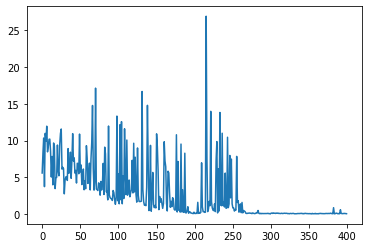

In [5]:
# plot your losses

import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# Play a game against your alphazero agent !

In [6]:
from Play import Play

In [11]:
%matplotlib

# as first player

gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)

Using matplotlib backend: TkAgg


In [12]:
%matplotlib

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player1=Policy_Player_MCTS, 
              player2=None)

Using matplotlib backend: TkAgg
